# RADIAN Testing

This notebook contains some experiments relating to the operation of the RADIAN spatial data generator. The aim of this is to establish areas of the tool that can be improved, in particular the efficiency and speed of the points generation process itself.

First we'll load the necessary Python packages for some simple points generation with a given **.GeoJSON** polygon file.

In [1]:
# Package imports
import random
from random import randint

import os
import math
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import warnings
from shapely.geometry import Point, Polygon, LineString
from geojson import FeatureCollection

In [104]:


def uniform_points_generation(polygon, number_points):
    # Calculate max and min bounding regions for points
    min_x, min_y, max_x, max_y = polygon.bounds
    #cx, cy = polygon.centroid.x, polygon.centroid.y

    points = []
    accepted = 0 
    rejected = 0
    
    while len(points) < number_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        # Once points lie within the polygon, they are appended to the list
        if (random_point.within(polygon)):
            points.append(random_point)
            accepted += 1
        else:
            rejected += 1

    # List of points is converted to a GeoDataFrame
    df = pd.DataFrame(points, columns=['geometry'])
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf = gdf.set_crs(epsg=3857)

    return gdf, accepted, rejected

def plot_poly_with_points(polygon, points_df, plot_title):
    fig, ax = plt.subplots(figsize=(6,6))
    polygon = polygon.to_crs(epsg=3857)
    points_df = points_df.to_crs(epsg=3857)
    polygon.plot(ax=ax, facecolor="none", edgecolor='red')
    points_df.plot(ax=ax, markersize=1, color='red', edgecolor='black')
    
    cx.add_basemap(ax, attribution=False)
    ax.set_title(plot_title)
    ax.axis("off")
    plt.axis('equal')
    plt.show()

def poly_around_point(origin=Point([0,0]), shape_type='circle', radius=2500, crs=3857):
    origin = origin.to_crs(crs)
    origin = origin['geometry'][0]
    if shape_type == 'circle':
        shape = origin.buffer(radius)
        shape_df = pd.DataFrame(shape, columns=['geometry'])
        shape_gdf = gpd.GeoDataFrame(shape_df, crs=crs, geometry='geometry')
        print(shape_gdf)
    elif shape_type == 'square':
        origin = origin['geometry'][0]
        # This distance creates the square within the circular radius
        #square_dist = math.sqrt(radius**2 / 2)
        square_dist = radius
        p1 = Point(origin.x - square_dist, origin.y - square_dist)
        p2 = Point(origin.x - square_dist, origin.y + square_dist)
        p3 = Point(origin.x + square_dist, origin.y + square_dist)
        p4 = Point(origin.x + square_dist, origin.y - square_dist)
        point_list = [p1, p2, p3, p4]
        shape_geom = Polygon([[p.x, p.y] for p in point_list])
        shape_gdf = gpd.GeoDataFrame(index=[0], crs=f'epsg:{crs}', geometry=[shape_geom])
    elif shape_type == 'triangle':
        p1 = Point(origin.x - radius, origin.y)
        p2 = Point(origin.x + radius, origin.y + radius)
        p3 = Point(origin.x + radius, origin.y - radius)

        point_list = [p1, p2, p3]
        shape_geom = Polygon([[p.x, p.y] for p in point_list])
        shape_gdf = gpd.GeoDataFrame(index=[0], crs=f'epsg:{crs}', geometry=[shape_geom])

    shape_gdf.to_file(filename=f'scenarios/shape_testing/{shape_type}_test.geojson', driver='GeoJSON')

def get_poly_area(polygon):
    print(str(round(polygon.area[0]/10000, 2)) + "Km^2")

def plot_poly(filename, crs):
    polygon = gpd.read_file(filename)
    print("Polygon info:\n")
    print(polygon)
    fig, ax = plt.subplots(figsize=(6,6))
    polygon.plot(ax=ax, facecolor="none", edgecolor='red')
    cx.add_basemap(ax, attribution=False)
    ax.axis("off")
    plt.axis('equal')
    plt.show()

def radian_lite(poly_filename, number_points, plot):
    print("Running RADIAN-lite...")
    print("#"*85)

    # Load source polygon
    print(f"\tReading {poly_filename}...")
    source_polygon = gpd.read_file(poly_filename)
    #source_polygon = source_polygon.to_crs(epsg=3857)
    print(f"\t{poly_filename} loaded as source polygon.")
    get_poly_area(source_polygon)    
    print("#"*85)

    # Generate points within polygon
    print(f"\tGenerating {number_points} points within the given polygon...")
    uniform_points_gdf, accepted_points, rejected_points = uniform_points_generation(source_polygon['geometry'][0], number_points=500)
    print(f"\tPoints generated successfully.")
    print(f"\t\t{accepted_points} accepted points.\n\t\t{rejected_points} rejected points")
    print("#"*85)

    if plot:
        # Plotting points
        print(f"\tPlotting generated points with source polygon...")
        plot_title = f"{number_points} points generated in source polygon:"
        plot_poly_with_points(source_polygon, uniform_points_gdf, plot_title)
        print(f"\tPoints plotted.")
        print("#"*85)

    print("RADIAN generation complete.")


circle_df = pd.DataFrame([Point([-6.5991454, 53.382711])], columns=['geometry'])
circle_centre = gpd.GeoDataFrame(circle_df, crs=4326, geometry='geometry')
#poly_around_point(origin=circle_centre, shape_type='triangle')
#plot_poly("scenarios/shape_testing/circle_test.geojson", 3857)
get_poly_area(gpd.read_file("scenarios/shape_testing/square_test.geojson"))
get_poly_area(gpd.read_file("scenarios/shape_testing/circle_test.geojson"))
get_poly_area(gpd.read_file("scenarios/shape_testing/triangle_test.geojson"))



2500.0Km^2
1960.34Km^2
1250.0Km^2


C:\Users\Paddy\AppData\Local\Temp\ipykernel_25868\940049405.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(str(round(polygon.area[0]/10000, 2)) + "Km^2")
C:\Users\Paddy\AppData\Local\Temp\ipykernel_25868\940049405.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(str(round(polygon.area[0]/10000, 2)) + "Km^2")
C:\Users\Paddy\AppData\Local\Temp\ipykernel_25868\940049405.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(str(round(polygon.area[0]/10000, 2)) + "Km^2")


In [105]:
radian_lite("scenarios/shape_testing/circle_test.geojson", 100, plot=False)
radian_lite("scenarios/shape_testing/square_test.geojson", 100, plot=False)
radian_lite("scenarios/shape_testing/triangle_test.geojson", 100, plot=False)


Running RADIAN-lite...
#####################################################################################
	Reading scenarios/shape_testing/circle_test.geojson...
	scenarios/shape_testing/circle_test.geojson loaded as source polygon.
1960.34Km^2
#####################################################################################
	Generating 100 points within the given polygon...
	Points generated successfully.
		500 accepted points.
		148 rejected points
#####################################################################################
RADIAN generation complete.
Running RADIAN-lite...
#####################################################################################
	Reading scenarios/shape_testing/square_test.geojson...
	scenarios/shape_testing/square_test.geojson loaded as source polygon.
2500.0Km^2
#####################################################################################
	Generating 100 points within the given polygon...
	Points generated successfully.
		500 ac

C:\Users\Paddy\AppData\Local\Temp\ipykernel_25868\940049405.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(str(round(polygon.area[0]/10000, 2)) + "Km^2")
C:\Users\Paddy\AppData\Local\Temp\ipykernel_25868\940049405.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(str(round(polygon.area[0]/10000, 2)) + "Km^2")
C:\Users\Paddy\AppData\Local\Temp\ipykernel_25868\940049405.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(str(round(polygon.area[0]/10000, 2)) + "Km^2")


## Improving the Generation Process

### The current method:
* Point co-ordinates are generated randomly (using the Pyhton `random` package) from a uniform distribution, with the possible x/y (lat/lon) values being bound by the max and min values given by the bounding box of the source polygon
* The fixed max and minimum values results in points being generated outside of the source polygon, but within the bounding box of the polygon, thus they are rejected and not included in the final dataframe.
### How to fix this
* One method would be to dynamically adjust the max/min ranges for the generated co-ordinates, depending on what stage of the generation RADIAN is at. The generation of X and Y could be adjusted so that rather than simply generating from a uniform distribution between a set max and min...
* Using a trasformaton that would map a given point in a fixed plane (i.e. the bounding box of the source polygon) to points in the polygon itself. That is to say, a point generated outside of the bounds of the polygon, but within the bounding box, would be mapped/transformed to have it's coordinates lie inside the polygon instead.


	Reading scenarios/Kildare/kildare.geojson...
Transforming to EPSG:3857...
EPSG:3857
current line: LINESTRING (-759088.2296350091 7018713.982861551, -772319.7337934208 6967082.254137248)
Equation of the line: y = 3.9021813473473803x + 9980813.913534228
current line: LINESTRING (-759088.2296350091 7018713.982861551, -725234.5243697523 7055749.206948047)
Equation of the line: y = 1.093978452175615x + 7849140.149382386
current line: LINESTRING (-759088.2296350091 7018713.982861551, -728903.5017274407 7057889.443740032)
Equation of the line: y = 1.2978570155889202x + 8003901.967144322
current line: LINESTRING (-759088.2296350091 7018713.982861551, -728903.5017274407 7057889.443740032)
Equation of the line: y = 1.2978570155889202x + 8003901.967144322
current line: LINESTRING (-759088.2296350091 7018713.982861551, -772319.7337934208 6967082.254137248)
Equation of the line: y = 3.9021813473473803x + 9980813.913534228
current line: LINESTRING (-759088.2296350091 7018713.982861551, -768956.5045

c:\Users\Paddy\miniconda3\envs\radian\Lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


CRSError: The EPSG code is unknown. PROJ: proj_create_from_database: C:\Program Files\PostgreSQL\15\share\contrib\postgis-3.3\proj\proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.

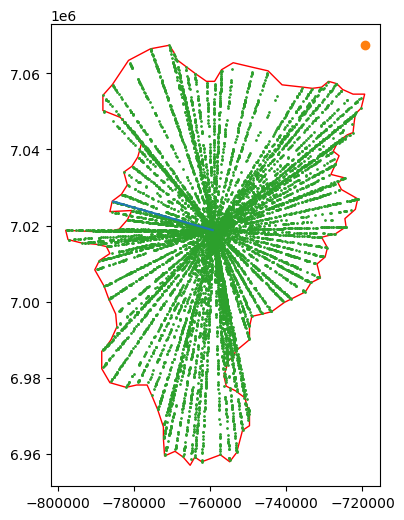

In [55]:
# test with an actual radian generation

def circular_points_generation(polygon, number_points):
    # Calculate max and min bounding regions for points
    min_x, min_y, max_x, max_y = polygon.bounds
    cent_x, cent_y = polygon.centroid.x, polygon.centroid.y

    points = []
    accepted = 0 
    rejected = 0
    
    while len(points) < number_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        # Once points lie within the polygon, they are appended to the list
        if (random_point.within(polygon)):
            points.append(random_point)
            accepted += 1
        else:
            rejected += 1

    # List of points is converted to a GeoDataFrame
    df = pd.DataFrame(points, columns=['geometry'])
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf = gdf.set_crs(epsg=3857)

    print("Accepted points:", accepted)
    print("Rejected points:", rejected)

    return gdf

def get_equation_between(a, b):
    # y = mx + c
    m = (b.y - a.y) / (b.x - a.x)
    # c = y - mx
    c = b.y - m*b.x

def points_rotation():
    # x_new = x*cos(theta) + y*sin(theta)
    # y_new = -x*sin(theta) + y*cos(theta)
    return

def points_along_line(line, num_points):
    points = []
    a = Point(line.coords[0])
    b = Point(line.coords[1])
    min_x = a.x
    max_x = b.x

    print("current line:", line)
    # y = mx + c
    m = (b.y - a.y) / (b.x - a.x)
    # c = y - mx
    c = b.y - m*b.x

    print(f"Equation of the line: y = {m}x + {c}")
    for i in range(num_points):
        rand_x = random.uniform(min_x, max_x)
        random_point = Point([rand_x, m*rand_x + c])
        points.append(random_point)

    return points

    """
    while len(points) < number_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        # Once points lie within the polygon, they are appended to the list
        if (random_point.within(polygon)):
            points.append(random_point)
            accepted += 1
        else:
            rejected += 1
    """

def flatten(l):
    return [item for sublist in l for item in sublist]

def radial_test(points = 100, poly_filename="scenarios/shape_testing/circle_test.geojson", plot=False):
    # Load source polygon
    print(f"\tReading {poly_filename}...")
    source_polygon = gpd.read_file(poly_filename)
    if source_polygon.crs == 'epsg:4326':
        print("Transforming to EPSG:3857...")
        source_polygon = source_polygon.to_crs(epsg=3857)
    print(source_polygon.crs)

    perimeter_points = list(source_polygon['geometry'][0].exterior.coords)
    
    source_origin = source_polygon.centroid[0]
    cent_x, cent_y = source_origin.x, source_origin.y
    source_bounds = source_polygon.bounds

    source_radius = math.sqrt((source_bounds['maxx'])**2 + (source_bounds['maxy'])**2)
    
    max_point = Point([source_bounds['maxx'], source_bounds['maxy']])

    test_lines = []
    points_list = []
    for i in range(1080):
        theta = (2*math.pi)/360
        x_new = ((max_point.x-cent_x) * math.cos(theta)) - ((max_point.y-cent_y) * math.sin(theta))
        y_new = ((max_point.x-cent_x) * math.sin(theta)) + ((max_point.y-cent_y) * math.cos(theta))
        rand_perim_point = Point(perimeter_points[random.randint(0, len(perimeter_points)-1)])
        test_line = LineString([source_origin, rand_perim_point])
        test_lines.append(test_line)
        points_current = points_along_line(test_line, 10)
        points_list.append(points_current)



    print(type(test_lines[0]))
    lines_gdf = gpd.GeoDataFrame(pd.DataFrame(test_lines, columns=['geometry']), crs=3857, geometry='geometry')
    print(type((points_list[0])))
    points_gdf = gpd.GeoDataFrame(pd.DataFrame(flatten(points_list), columns=['geometry']), crs=3857, geometry='geometry')
    
    lines_difference = lines_gdf.difference(source_polygon)

    if plot:
        fig, ax = plt.subplots(figsize=(6,6))
        source_polygon.plot(aspect=1, ax=ax, facecolor="none", edgecolor='red')
        gpd.GeoSeries(source_origin).plot(aspect=1, ax=ax)
        gpd.GeoSeries(test_line).plot(aspect=1, ax=ax)
        gpd.GeoSeries(max_point).plot(aspect=1, ax=ax)
        points_gdf.plot(aspect=1, markersize=1, ax=ax)
        lines_difference.plot(aspect=1, ax=ax)
        cx.add_basemap(ax, crs=source_polygon.crs, attribution=False)
        #ax.axis("off")
        plt.axis('equal')
        plt.show()

radial_test(poly_filename="scenarios/Kildare/kildare.geojson", plot=True)


C:\Users\Paddy\AppData\Local\Temp\ipykernel_13356\3983484320.py:12: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_poly_exterior = gpd.GeoDataFrame({'geometry': [polygon.buffer(-0.1).exterior]}).explode().reset_index()
c:\Users\Paddy\miniconda3\envs\radian\Lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\Paddy\miniconda3\envs\radian\Lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\Paddy\miniconda3\envs\radian\Lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\Paddy\miniconda3\envs\radian\Li

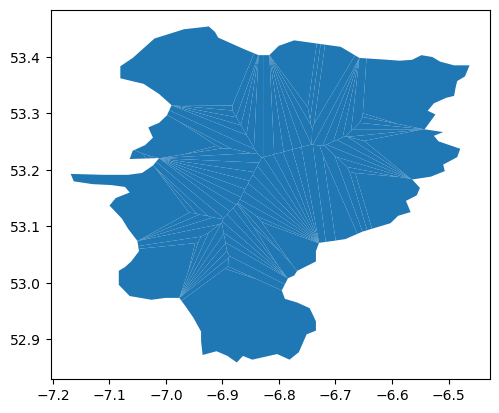

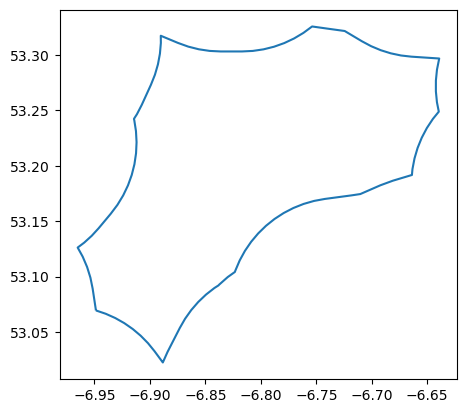

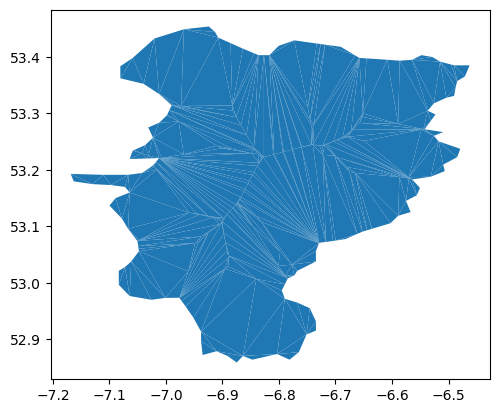

In [66]:
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import triangulate
import shapely.wkt
import geopandas as gpd
from geovoronoi import voronoi_regions_from_coords

def to_triangles(polygon):

    poly_points = []

    gdf_poly_exterior = gpd.GeoDataFrame({'geometry': [polygon.buffer(-0.1).exterior]}).explode().reset_index()
    for geom in gdf_poly_exterior.geometry:
        poly_points += np.array(geom.coords).tolist()

    try:
        polygon.interiors[0]
    except:
        poly_points = poly_points
    else:
        gdf_poly_interior = gpd.GeoDataFrame({'geometry': [polygon.interiors]}).explode().reset_index()
        for geom in gdf_poly_interior.geometry:
          poly_points += np.array(geom.coords).tolist()

    poly_points = np.array([item for sublist in poly_points for item in sublist]).reshape(-1,2)

    poly_shapes, pts = voronoi_regions_from_coords(poly_points, polygon)
    gdf_poly_voronoi = gpd.GeoDataFrame({'geometry': poly_shapes}).explode().reset_index()
    gdf_poly_voronoi.plot()

    tri_geom = []
    for geom in gdf_poly_voronoi.geometry:
        inside_triangles = [tri for tri in triangulate(geom) if tri.centroid.within(polygon)]
        tri_geom += inside_triangles

    gdf_poly_triangles = gpd.GeoDataFrame({'geometry': tri_geom})

    gdf_poly_exterior.plot()
    if 'gdf_poly_interior' in locals():
        gdf_poly_interior.plot()
    gdf_poly_triangles.plot()

polygon_1 = Polygon([(0, 0), (0, 3), (5, 3), (2, 4), (6, 4), (6, 0)])
polygon_2 = Polygon([(3.0, 0.0), (2.0, 0.0), (2.0, 0.75), (2.5, 0.75), (2.5, 0.6), (2.25, 0.6), (2.25, 0.2), (3.0, 0.2), (3.0, 0.0)])
poly_3_wkt = 'POLYGON ((-74.05644319847762 4.664371152795165, -74.05701264773319 4.663503533579181, -74.05770573357918 4.662810447733186, -74.05896428283818 4.662056102337443, -74.05990224838993 4.661771573597983, -74.06224145161008 4.661772473597984, -74.06317941716183 4.662057002337444, -74.06443796642083 4.662811347733187, -74.06572065226682 4.664052233579182, -74.06921901369725 4.668360960588712, -74.07141674761461 4.670691972117472, -74.07635895116509 4.673818151938486, -74.07894493390593 4.675834266094067, -74.08192435226682 4.679424333579181, -74.08891615226682 4.688383433579182, -74.08958587724112 4.689463067989243, -74.09086467349047 4.690719228823506, -74.09790275116509 4.694460551938487, -74.10034036642082 4.696114147733187, -74.10386724657296 4.698958762835078, -74.10814346936803 4.700870863662334, -74.10930545161006 4.700957773597984, -74.11043741716183 4.701320402337444, -74.11139045116509 4.701828051938487, -74.11214813390593 4.702449866094067, -74.11445885226682 4.704984433579183, -74.11521319766256 4.706242982838176, -74.11590442640203 4.70845234838992, -74.11611382363337 4.710865185701647, -74.11554750632175 4.71273208368413, -74.11467343390593 4.713910633905932, -74.11305131716183 4.714994497662556, -74.11211335161008 4.715279026402015, -74.11073328554708 4.715355222566556, -74.11041129766257 4.716545717161825, -74.1094660522668 4.718057466420818, -74.10756213390592 4.720161033905933, -74.10568445116508 4.721873348061513, -74.10420772338625 4.722584201678661, -74.10275629999998 4.7227995, -74.10130487661371 4.722584201678661, -74.09995094883489 4.721945648061514, -74.09403374773316 4.716245366420819, -74.09338219367824 4.71525808368413, -74.09288787359796 4.71387655161008, -74.09288787359796 4.711925648389919, -74.0936469519385 4.710096948834901, -74.09548963357916 4.708043347733187, -74.09763068874044 4.70677727898599, -74.09460666784895 4.704312469919607, -74.09203589291714 4.702595752799392, -74.08765371631586 4.700417706321742, -74.08459603357916 4.698508252266813, -74.08273894773316 4.696641066420818, -74.08206922275886 4.695561432010757, -74.08118604773318 4.694727366420818, -74.0717936025263 4.682825210334004, -74.06562484883489 4.678834648061513, -74.06390001213198 4.677314420684328, -74.0535710885149 4.739037649974117, -74.05520778283815 4.737937702337444, -74.05712119999998 4.7375571, -74.06045152338628 4.738003698321339, -74.06217206642083 4.738923347733187, -74.06340970632175 4.74043141631587, -74.06393542640203 4.74187004838992, -74.06400742363337 4.743335585701648, -74.063537026402 4.74698295161008, -74.06279044806149 4.748785351165098, -74.06139073691359 4.75018144712255, -74.0609743487264 4.751890490745711, -74.06128649999999 4.753612599999999, -74.06107120167866 4.755064023386272, -74.06039964806149 4.756487551165098, -74.0594142664208 4.757574752266813, -74.05806621716184 4.758372197662556, -74.05615280000001 4.7587528, -74.05377854838993 4.758482026402016, -74.0507277649826 4.757844764394359, -74.05055722640202 4.75945045161008, -74.04983964400328 4.762451751932777, -74.04873032640204 4.76925805161008, -74.04829449766255 4.770818617161826, -74.04766074258318 4.772140089033794, -74.04726809766255 4.773711517161825, -74.04651375226682 4.774970066420818, -74.04542655116509 4.775955448061513, -74.04410012338627 4.776582801678661, -74.04215861429836 4.776774023633361, -74.04029171631588 4.776207706321742, -74.03878364773318 4.774970066420818, -74.03800540233745 4.773666917161825, -74.03729177636662 4.771281485701648, -74.03727967636664 4.770004014298352, -74.03747549832134 4.769002476613728, -74.03843161386389 4.767199327773277, -74.04047532279198 4.75512284897233, -74.0369408023945 4.754256982815782, -74.03025007661371 4.753148101678661, -74.02876484883491 4.752415548061514, -74.02767764773319 4.751430166420819, -74.02692330233745 4.750171617161826, -74.02654087636664 4.748620285701648, -74.02683367636664 4.736912214298353, -74.02739999367826 4.73504531631587, -74.02863763357918 4.733537247733187, -74.03035817661373 4.732617598321339, -74.03229968570164 4.732426376366639, -74.03372301716183 4.732782902337444, -74.03534513390593 4.733866766094067, -74.03621920632175 4.73504531631587, -74.03676491551958 4.736773285680133, -74.04355019487681 4.738452884397855, -74.04767016881966 4.714185707761746, -74.04885077359798 4.706409648389919, -74.05027314410287 4.698677293675041, -74.05045487359796 4.696561148389919, -74.05077748485968 4.695365046361829, -74.05289107166563 4.682999393176747, -74.05422957359798 4.67404324838992, -74.05473458359565 4.671889824337649, -74.05543207359798 4.667273848389919, -74.05644319847762 4.664371152795165))'
polygon_3 = shapely.wkt.loads(poly_3_wkt)
poly_4_wkt = 'Polygon ((22.11315279161000547 -25.09231820047121886, 21.62718174901616663 -26.2204652636354929, 22.01769419395764515 -27.5308514677724574, 23.33675845242663982 -28.13831527101475416, 24.77731547154409597 -27.47010508744822488, 24.86409601486442256 -26.98413404485438605, 23.92686614700487624 -26.97545599052235232, 24.55168605891124045 -26.38534829594411946, 25.86207226304820495 -26.14236277464719649, 26.1918383276654545 -26.70643630622933529, 25.92281864337243391 -27.30522205513960188, 26.69516547892335723 -26.88867544720202218, 26.75591185924758975 -26.19443110063939528, 25.93149669770446764 -25.73449422104165407, 25.51495008976689149 -25.98615779667060366, 25.14179375348947687 -25.69978200371352273, 24.68185687389173566 -25.25720123277984541, 23.85744171234861355 -26.09029444865500125, 23.71859284303608462 -26.81925101254575949, 22.81607519250466964 -26.2204652636354929, 23.26733401777037713 -25.343981776100172, 23.17187542011801682 -24.90140100516649824, 22.77268492084450457 -24.55427883188518123, 22.11315279161000547 -25.09231820047121886),(22.46027496489132247 -25.79524060136588304, 22.01769419395764515 -26.19443110063939528, 22.2172894435943995 -26.38534829594411946, 22.45159691055928874 -26.48948494792850994, 22.55573356254368278 -26.53287521958867501, 22.49498718221945381 -26.75850463222153053, 22.92021184448906368 -26.68908019756526784, 22.33010414991082726 -26.32460191561988694, 22.5817677255397804 -26.02087001399873856, 22.93756795315312758 -25.3786939934283069, 22.81607519250466964 -25.343981776100172, 22.46027496489132247 -25.79524060136588304),(23.10245098546175413 -27.53952952210448757, 22.54705550821164906 -27.47010508744822488, 22.81607519250466964 -27.05355847951064874, 23.64049035404779175 -27.17505124015910667, 23.692558680039987 -27.59159784809668636, 23.18055347445005054 -27.85193947805767323, 23.10245098546175413 -27.53952952210448757),(24.24795415729009207 -26.20310915497142901, 24.36076886360651983 -25.94276752501044214, 24.70789103688783328 -25.95144557934247587, 24.81202768887222732 -25.95144557934247587, 24.77731547154409597 -25.78656254703384931, 25.0810473731652479 -25.91673336201434097, 25.07236931883321418 -26.10765055731906514, 24.65582271089563449 -26.15104082897923021, 24.34341275494245238 -26.38534829594411946, 24.24795415729009207 -26.20310915497142901))'
polygon_4 = shapely.wkt.loads(poly_4_wkt)
poly_kildare = gpd.read_file("scenarios/kildare/kildare.geojson")['geometry'][0]

to_triangles(poly_kildare)

In [132]:
import geopandas as gpd
import pandas as pd
from pandas import Series
import shapely
from shapely import geometry
from shapely.geometry import MultiPolygon, Polygon
import matplotlib.pyplot as plt

def create_raster_grid(file_dir='scenarios/kildare/kildare.geojson',size_in_km=1, to_file=False, plot=False):
    # Create a fishnet 
    # Read the shapefile
    gdf = gpd.read_file(file_dir)
    # Reproject to projected coordinate system
    gdf = gdf.to_crs('EPSG:3857')
    poly = gdf['geometry'][0]
    poly_centroid = poly.centroid

    # Get the extent of the shapefile
    total_bounds = gdf.total_bounds
 
    # Get minX, minY, maxX, maxY
    minX, minY, maxX, maxY = total_bounds
 
    # Create a fishnet
    x, y = (minX, minY)
    geom_array = []
 
    # Polygon Size
    square_size = size_in_km * 1000
    while y <= maxY:
        while x <= maxX:
            geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size

    fishnet_dist = gpd.GeoDataFrame({'geometry': geom_array}).set_crs('EPSG:3857')
    fishnet_dist['dist_to_centroid'] = 0
    for i in range(0, len(fishnet_dist['geometry'])):
        geom_dist = poly_centroid.distance(fishnet_dist['geometry'][i].centroid) / 1000
        #fishnet_dist['dist_to_centroid'][i] = geom_dist
        fishnet_dist.loc[i, 'dist_to_centroid'] = geom_dist


    fishnet = gpd.GeoSeries(geom_array).set_crs('EPSG:3857')
    #fishnet.to_file("scenarios/kildare/kildare_fishnet.geojson")

    poly_contains = gdf['geometry'][0].contains(fishnet)
    poly_raster = fishnet[poly_contains==True]
    if to_file:
        poly_raster.to_file(f"scenarios/kildare/kildare_raster_{size_in_km}.geojson")
        fishnet_dist.to_file(f"scenarios/kildare/fishnet_distances.geojson")

    
    poly_buffer1 =  poly.buffer(-5000, join_style=2)
    buffer1 = poly_buffer1.contains(poly_raster)
    
    poly_buffer2 =  poly.buffer(-10000, join_style=2)
    buffer2 = poly_buffer2.contains(poly_raster)
    
    poly_buffer3 =  poly.buffer(-15000, join_style=2)
    buffer3 = poly_buffer3.contains(poly_raster)
 
    raster_A = poly_raster
    raster_B = poly_raster[buffer1==False]
    raster_C = poly_raster[buffer2==True]
    raster_D = poly_raster[buffer3==True]
    

    gdf_buffers = gpd.GeoDataFrame({'geometry': [poly_buffer1, poly_buffer2, poly_buffer3, poly]})

    if plot:
        fig, ax = plt.subplots(figsize=(10,15))

        #gdf.plot(ax=ax)
        #fishnet_dist.plot(ax=ax, facecolor='none', edgecolor='black')
        #gdf_buffers.plot(ax=ax, facecolor='none', edgecolor='green')
        raster_A.plot(ax=ax, facecolor='green', edgecolor='black')
        raster_B.plot(ax=ax, facecolor='pink', edgecolor='black')
        raster_C.plot(ax=ax, facecolor='orange', edgecolor='black')
        raster_D.plot(ax=ax, facecolor='red', edgecolor='black')

        plt.show()
        
    multi_A = shapely.geometry.MultiPolygon(raster_A.values.tolist())
    multi_B = shapely.geometry.MultiPolygon(raster_B.values.tolist())
    multi_C = shapely.geometry.MultiPolygon(raster_C.values.tolist())
    multi_D = shapely.geometry.MultiPolygon(raster_D.values.tolist())

    multi_list = [multi_A, multi_B, multi_C, multi_D]

    gdf_rasters = gpd.GeoDataFrame(pd.DataFrame(multi_list, columns=['geometry']), geometry='geometry')

    return gdf_rasters

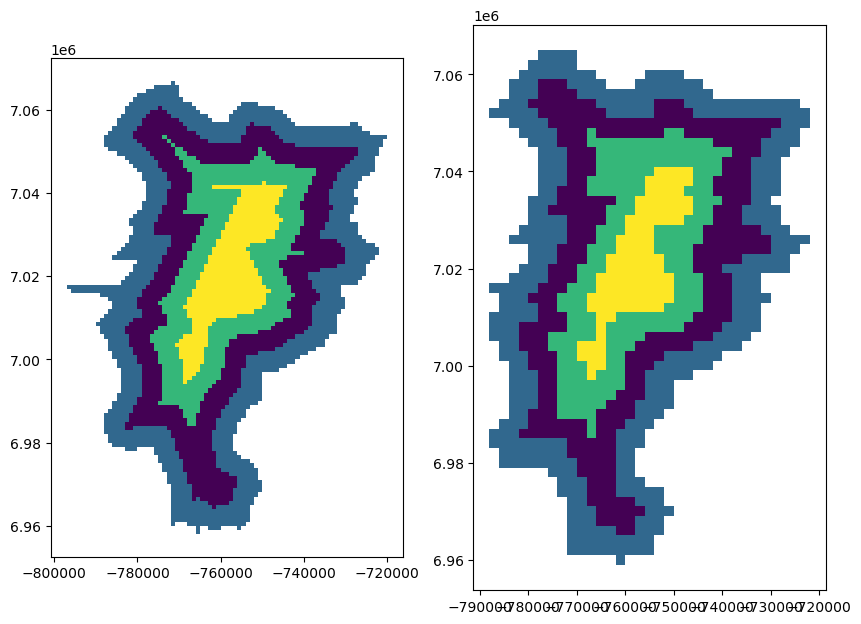

In [133]:
def raster_examples(file_dir='scenarios/kildare/kildare.geojson', num=2):
    fig, axs = plt.subplots(1,num,figsize=(10,6*num))

    raster_list = []
    for i in range(num):
        current_grid = create_raster_grid(file_dir, size_in_km=i+1, plot=False)
        current_grid.plot(ax=axs[i], cmap='viridis')
    plt.show()

raster_examples()

geometry    MULTIPOLYGON (((-770002.575 6960992.566, -7700...
Name: 0, dtype: geometry


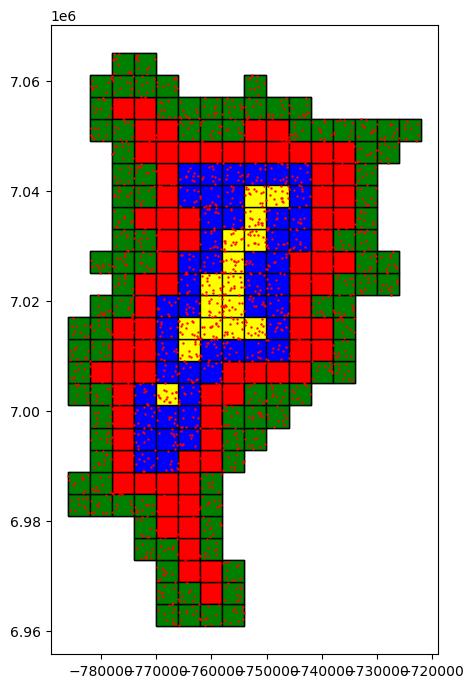

In [141]:
import random
from shapely.geometry import Point 

def uniform_points_in_polygon(polygon, num_points=50, to_list=False):
    points_list = []
    minX, minY, maxX, maxY = polygon.bounds
    while len(points_list) < num_points:
        current_point = Point([random.uniform(minX, maxX), random.uniform(minY, maxY)])
        points_list.append(current_point)

    if to_list:
        return points_list
    return gpd.GeoDataFrame(pd.DataFrame(points_list, columns=['geometry']), geometry='geometry')

kildare_grid = create_raster_grid(file_dir='scenarios/kildare/kildare.geojson',size_in_km=4, to_file=False, plot=False)

grid_one = kildare_grid.loc[0, 'geometry'].geoms[0]

grid_one_points = uniform_points_in_polygon(grid_one, 100)

print(kildare_grid.loc[0])


grid_points = []
for i in range(len(kildare_grid)):
    for polygon in kildare_grid.loc[i, 'geometry'].geoms:
        five_points = uniform_points_in_polygon(polygon, 5, True)
        grid_points += five_points

grid_gdf = gpd.GeoDataFrame(pd.DataFrame(grid_points, columns=['geometry']), geometry='geometry')

fig, ax = plt.subplots(figsize=(5,10))

gpd.GeoSeries(kildare_grid.loc[0]).plot(ax=ax, facecolor='red', edgecolor='black')
gpd.GeoSeries(kildare_grid.loc[1]).plot(ax=ax, facecolor='green', edgecolor='black')
gpd.GeoSeries(kildare_grid.loc[2]).plot(ax=ax, facecolor='blue', edgecolor='black')
gpd.GeoSeries(kildare_grid.loc[3]).plot(ax=ax, facecolor='yellow', edgecolor='black')

grid_gdf.plot(ax=ax, color='red', markersize=0.5)

plt.show()


In [153]:
kildare_grid = create_raster_grid(file_dir='scenarios/kildare/kildare.geojson',size_in_km=4, to_file=False, plot=False)

polygons = [[poly for poly in multipoly.geoms] for multipoly in kildare_grid['geometry']]
unique_polys = [] 

for poly in polygons:
    if not any(p.equals(poly) for p in unique_polys):
        unique_polys.append(poly)

AttributeError: 'list' object has no attribute 'equals'